In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import networkx as nx
from tqdm import tqdm
import utils
import pickle
import random

In [2]:
with open('graph_objects/G_simple_directed.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)
    G_simple_directed.name = 'G_simple_directed'

----
# N-k MAX FLOW 

In [4]:
def W(flow_dict):
    """ 
    Computes flow matrix W after running max flow algorithm on the graph.
    Defined in Cai et al. (2021) as the flow matrix of the network prior to any node removal.
    
    Returns:
        flow_matrix: 2D numpy array representing the flow matrix
        node_indices: Dictionary mapping nodes to their corresponding indices
    """
    nodes = list(flow_dict.keys())
    num_nodes = len(nodes)
    node_indices = {node: i for i, node in enumerate(nodes)}
    flow_matrix = np.zeros((num_nodes, num_nodes))
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                flow_matrix[i, j] = flow_dict.get(nodes[i], {}).get(nodes[j], 0)
    
    return flow_matrix, node_indices


def W_c(flow_matrix, target, node_indices):
    """
    Computes the flow matrix W_c after removing a node.
    Defined in Cai et al. (2021) as the original flow matrix of the network after removing entry corresponding to the removed node.

    Parameters:
        flow_matrix: Flow matrix of the original graph
        target: Target can be either a single node or an edge in the form (v1, v2)
        node_indices: Dictionary mapping nodes to their indices in the flow matrix

    Returns:
        flow_matrix_c: Flow matrix after removing the specified node
        modified_flow_matrix: Modified flow matrix
    """

    modified_flow_matrix = np.copy(flow_matrix)

    if isinstance(target, (set,tuple)) and len(target) == 2:
        # Target is an edge in the form (v1, v2)
        v1, v2 = target
        index_v1 = node_indices.get(v1, None)
        index_v2 = node_indices.get(v2, None)

        if index_v1 is not None and index_v2 is not None:
            modified_flow_matrix[index_v1, index_v2] = 0
            modified_flow_matrix[index_v2, index_v1] = 0
    
    else:
        # Target is a single node
        removed_node_index = node_indices.get(target, None)

        # Exclude the row and column corresponding to the removed node
        if removed_node_index is not None and removed_node_index < modified_flow_matrix.shape[0]:
            modified_flow_matrix = np.delete(modified_flow_matrix, removed_node_index, axis=0)
            modified_flow_matrix = np.delete(modified_flow_matrix, removed_node_index, axis=1)

    return modified_flow_matrix

In [5]:
def flow_capacity_robustness(G_, heuristic='random', remove='node', k_removals=250, n_benchmarks = 20, all_to_all_flow=True, log_graph_state=False, flow_func=nx.algorithms.flow.dinitz):
    """ 
    Computes the n-k capacity robustness based on maximum flow of a graph
    """

    # Make a copy of the graph
    G = G_.copy()
    
    # Initialize the sources and sinks
    sources, sinks = None, None
    G, sources, sinks = utils.country_or_node_analysis(G, sources, sinks, all_to_all_flow)

    super_source, super_sink = utils.add_super_source_sink(G, sources, sinks)

    # Calculate the original flow matrix W of the graph
    flow_val, flow_dict = nx.maximum_flow(G.copy(), super_source, super_sink, flow_func=flow_func, capacity='max_cap_M_m3_per_d')
    flow_matrix, node_indices = W(flow_dict)

    # Instantiate the results dataframe
    if log_graph_state:
        results_df = pd.DataFrame(columns=['max_flow_value', 'capacity_robustness_max_flow', 'heuristic', 'removed_entity', 'entity_data', 'sources', 'sinks', 'network_state', 'flow_dict', 'comment'])
        results_df.loc[0] = [flow_val, 1, None, None, None, sources, sinks, G.copy(), flow_dict, 'No removals made']
    else:
        results_df = pd.DataFrame(columns=['max_flow_value', 'capacity_robustness_max_flow', 'heuristic', 'removed_entity'])
        results_df.loc[0] = [flow_val, 1, None, None]

    # Helper function to check if a node is valid
    def node_is_valid(n, sources, sinks, g):
        return n not in sources and n not in sinks and n != 'super_source' and n != 'super_sink' and n in g.nodes()
    
    # Helper function to check if an edge is valid
    def edge_is_valid(src, snk, sources, sinks, g):
        return src not in sources and snk not in sinks and src != 'super_source' and snk != 'super_sink' and (src, snk) in g.edges() 

    # Helper function to perform a targeted removal   
    def perform_targeted_removal(G, heuristic, sources, sinks, target, flow_matrix, node_indices, results_df):
        """
        Perform a targeted removal of a node or edge based on the heuristic. Target to remove is always an edge.
        """
        if not isinstance(target, (set,tuple)):
            raise ValueError("Target must be an edge. Use Graph.remove_node() to remove a node.")

        if remove == 'edge':
                target_data = G.get_edge_data(*target)
                G.remove_edge(*target)
        else:
            target_data = None

            # Use source node of the edge as the target node to remove
            if target[0] not in sources:
                target = target[0]
                target_data = G.nodes[target]
                G.remove_node(target)
            
            # Else, use sink node of the edge as the target node to remove
            elif target[1] not in sinks:
                target = target[1]
                target_data = G.nodes[target]
                G.remove_node(target)
            
            # Else, use the source node of the edge as the target node to remove regardless of the source and sink status
            elif target[0] in sources:
                target = target[0]
                sources.remove(target)
                target_data = G.nodes[target]
                G.remove_node(target)

            if isinstance(target, pd.DataFrame):
                return results_df
            
        # Calculate the flow matrix W_c after removing the node or edge
        flow_matrix = W_c(flow_matrix, target, node_indices)
        W_c_ = flow_matrix
        
        # Recompute W_c_prime (flow matrix) after the network has sustained damage
        current_max_flow_val, current_flow_dict = nx.maximum_flow(G.copy(), super_source, super_sink, flow_func=flow_func, capacity='max_cap_M_m3_per_d')
        W_c_prime, _ = W(current_flow_dict)
        
        # Calculate the flow capacity robustness
        flow_capacity_robustness = np.sum(W_c_prime) / np.sum(W_c_)

        # Append to the results dataframe
        target = target if remove == 'node' else set(target)
        if log_graph_state:
            results_df.loc[k] = [current_max_flow_val, flow_capacity_robustness, heuristic, target, target_data, sources, sinks, G.copy(), current_flow_dict, None]
        else:
            results_df.loc[k] = [current_max_flow_val, flow_capacity_robustness, heuristic, target]

    # Heuristic specific initializations
    if heuristic == 'random':
        G_lst = [G.copy() for _ in range(n_benchmarks)]
        G_flow_matrix_lst = [flow_matrix for _ in range(n_benchmarks)]
    if heuristic == 'load_rate':
        edge_capacities = {(node1, node2): data['max_cap_M_m3_per_d'] for node1, node2, data in G_simple_directed.edges(data=True) if 'max_cap_M_m3_per_d' in data}
    if heuristic == 'max_flow_edge_count':
        prev_max_flow_vals = {}
    if heuristic == 'min_cutset_edge_count':
        observed_min_cutset_edge_counts = {}

    # N-k capacity robustness calculation
    for k in tqdm(range(1, k_removals + 1), desc='N-k capacity robustness'):

        if heuristic == 'random':
            max_flow_lst, capacity_robustness_lst = [], []

            for G_copy, G_flow_matrix in zip(G_lst, G_flow_matrix_lst):

                valid_targets = [target for target in (G_copy.nodes() if remove == 'node' else G_copy.edges()) if node_is_valid(target, sources, sinks, G_copy) or edge_is_valid(target[0], target[1], sources, sinks, G_copy)]
                target = random.choice(valid_targets)
                
                if remove == 'edge':
                    target_data = G_copy.get_edge_data(*target)
                    G_copy.remove_edge(*target)
                else:
                    target_data = G_copy.nodes[target]
                    G_copy.remove_node(target)

                G_flow_matrix = W_c(G_flow_matrix, target, node_indices)
                W_c_ = G_flow_matrix

                current_max_flow_val, current_flow_dict = nx.maximum_flow(G_copy.copy(), super_source, super_sink, flow_func=flow_func, capacity='max_cap_M_m3_per_d')
                W_c_prime, _ = W(current_flow_dict)

                capacity_robustness_lst.append(np.sum(W_c_prime) / np.sum(W_c_))
                max_flow_lst.append(current_max_flow_val)
            
            target = target if remove == 'node' else set(target)
            if log_graph_state:
                results_df.loc[k] = [np.mean(max_flow_lst), np.mean(capacity_robustness_lst), 'random', target, target_data, sources, sinks, G_copy.copy(), current_flow_dict,'Specimen graph, averaged across '+str(n_benchmarks)+' benchmarks']
            else:
                results_df.loc[k] = [np.mean(max_flow_lst), np.mean(capacity_robustness_lst), 'random', target]
        
        elif heuristic == 'load_rate':
            current_max_flow_val, current_flow_dict = nx.maximum_flow(G.copy(), super_source, super_sink, flow_func=flow_func, capacity='max_cap_M_m3_per_d')

            flow_edges = {(source, target): flow for source, targets in current_flow_dict.items() for target, flow in targets.items() if flow != 0}
            sorted_edge_loads = dict(sorted({edge: flow / edge_capacities[edge] for edge, flow in flow_edges.items() if edge in edge_capacities}.items(), key=lambda item: item[1], reverse=True))
            
            if len(sorted_edge_loads) == 0:
                return results_df
     
            perform_targeted_removal(G, 'load_rate', sources, sinks, list(sorted_edge_loads.keys())[0], flow_matrix, node_indices, results_df)
        

        elif heuristic == 'max_flow':
            current_max_flow_val, current_flow_dict = nx.maximum_flow(G.copy(), super_source, super_sink, flow_func=flow_func, capacity='max_cap_M_m3_per_d')

            # Find the edge that maximizes the flow
            max_flow, target = float('-inf'), None
            max_flow, target = max(((flow, (source, sink)) for source, edges in current_flow_dict.items() for sink, flow in edges.items() if edge_is_valid(source, sink, sources, sinks, G) and node_is_valid(source, sources, sinks, G) and flow > max_flow), key=lambda x: x[0], default=(float('-inf'), None))
    
            perform_targeted_removal(G, 'max_flow', sources, sinks, target, flow_matrix, node_indices, results_df)

        
        elif heuristic == 'max_flow_edge_count':
            target_df, prev_max_flow_vals = utils.max_flow_edge_count(G, prev_max_flow_vals.copy(), k)

            if target_df.empty:
                return results_df
                    
            perform_targeted_removal(G, 'max_flow_edge_count', sources, sinks, target_df.iloc[0].edge, flow_matrix, node_indices, results_df)

        elif heuristic == 'min_cutset_edge_count':
            target_df, observed_min_cutset_edge_counts = utils.edge_cutset_count(G, observed_min_cutset_edge_counts.copy(), k)

            perform_targeted_removal(G, 'min_cutset_edge_count', sources, sinks, target_df.iloc[0].edge, flow_matrix, node_indices, results_df)


        else:
            raise ValueError("Invalid heuristic")


    return results_df

----
# Heuristics

### Node removal ('sinks-to-sources')

In [6]:
# random_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='random', remove='node')
# random_node_removal_df.to_pickle('results/random_node_removal_df.pkl')
random_node_removal_df = pd.read_pickle('results/random_node_removal_df.pkl')

In [7]:
# load_rate_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='load_rate', remove='node')
# load_rate_node_removal_df.to_pickle('results/load_rate_node_removal_df.pkl')
load_rate_node_removal_df = pd.read_pickle('results/load_rate_node_removal_df.pkl')

In [8]:
# max_flow_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow', remove='node')
# max_flow_node_removal_df.to_pickle('results/max_flow_node_removal_df.pkl')
max_flow_node_removal_df = pd.read_pickle('results/max_flow_node_removal_df.pkl')

In [9]:
"""
Runtime: 62m with k_removals=250 and grid configuration of 'sinks-to-sources'. 
"""
# max_flow_edge_count_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow_edge_count', remove='node')
# max_flow_edge_count_node_removal_df.to_pickle('results/max_flow_edge_count_node_removal_df.pkl')
max_flow_edge_count_node_removal_df = pd.read_pickle('results/max_flow_edge_count_node_removal_df.pkl')

In [10]:
# min_cutset_edge_count_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='min_cutset_edge_count', remove='node')
# min_cutset_edge_count_node_removal_df.to_pickle('results/min_cutset_edge_count_node_removal_df.pkl')
min_cutset_edge_count_node_removal_df = pd.read_pickle('results/min_cutset_edge_count_node_removal_df.pkl')

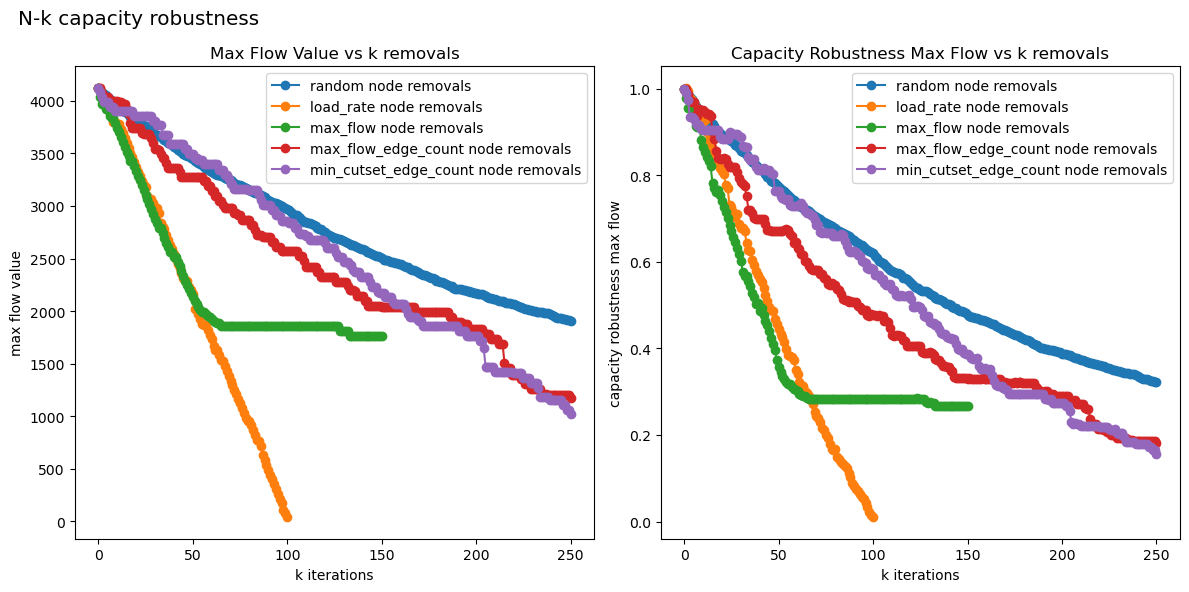

In [11]:
utils.plot_heuristic_comparison_biplot([random_node_removal_df, load_rate_node_removal_df, max_flow_node_removal_df, max_flow_edge_count_node_removal_df, min_cutset_edge_count_node_removal_df], 'N-k capacity robustness')

### Edge removal ('sinks-to-sources')

In [12]:
# random_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='random', remove='edge')
# random_edge_removal_df.to_pickle('results/random_edge_removal_df.pkl')
random_edge_removal_df = pd.read_pickle('results/random_edge_removal_df.pkl')

In [13]:
# load_rate_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='load_rate', remove='edge')
# load_rate_edge_removal_df.to_pickle('results/load_rate_edge_removal_df.pkl')
load_rate_edge_removal_df = pd.read_pickle('results/load_rate_edge_removal_df.pkl')

In [14]:
# max_flow_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow', remove='edge')
# max_flow_edge_removal_df.to_pickle('results/max_flow_edge_removal_df.pkl')
max_flow_edge_removal_df = pd.read_pickle('results/max_flow_edge_removal_df.pkl')

In [15]:
"""
92m with k_removals=250 and grid configuration of 'sinks-to-sources'. 
"""
# max_flow_edge_count_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow_edge_count', remove='edge')
# max_flow_edge_count_edge_removal_df.to_pickle('results/max_flow_edge_count_edge_removal_df.pkl')
max_flow_edge_count_edge_removal_df = pd.read_pickle('results/max_flow_edge_count_edge_removal_df.pkl')

In [16]:
# min_cutset_edge_count_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='min_cutset_edge_count', remove='edge')
# min_cutset_edge_count_edge_removal_df.to_pickle('results/min_cutset_edge_count_edge_removal_df.pkl')
min_cutset_edge_count_edge_removal_df = pd.read_pickle('results/min_cutset_edge_count_edge_removal_df.pkl')

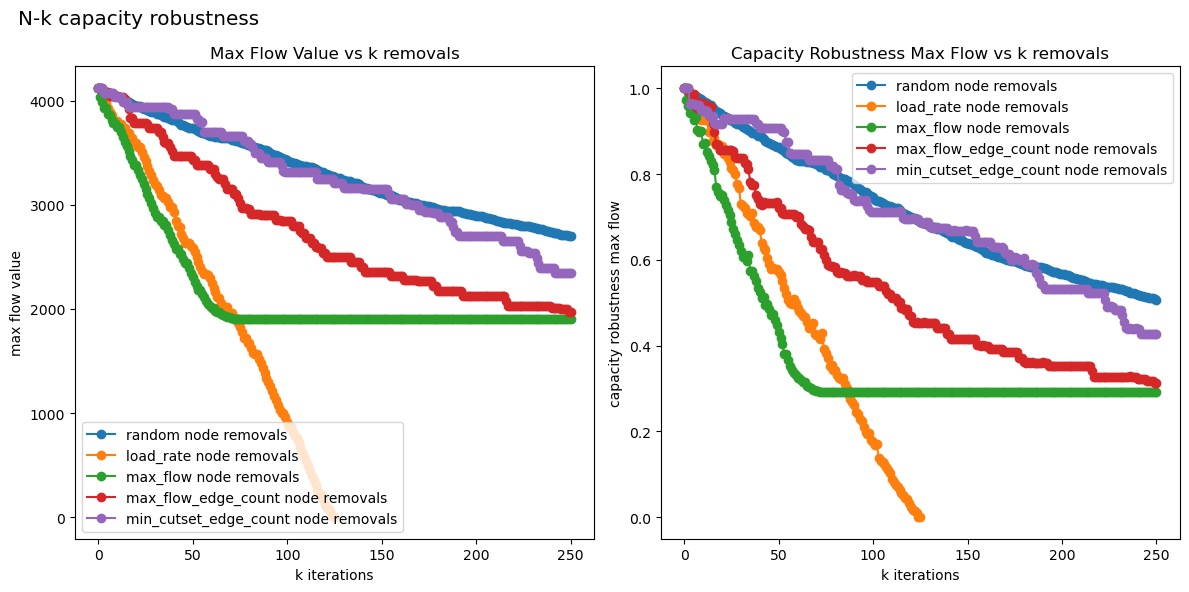

In [17]:
utils.plot_heuristic_comparison_biplot([random_edge_removal_df, load_rate_edge_removal_df, max_flow_edge_removal_df, max_flow_edge_count_edge_removal_df, min_cutset_edge_count_edge_removal_df], 'N-k capacity robustness')